In [2]:
import numpy as np
np.random.seed(554)
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
def parse_data():
    num = float
    dtype = np.float32
    data = []
    with open('points.dat', 'r') as f:
        for line in f:
            data.append([num(t) for t in line.split()])
    dev_cutoff = int(.9*len(data))
    train_xs = np.asarray(data[:dev_cutoff],dtype=dtype)
    dev_xs = np.asarray(data[dev_cutoff:],dtype=dtype)
    return train_xs, dev_xs
train_xs, dev_xs = parse_data()


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ian\Anaconda3\envs\gaus\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [11]:
train_xs.shape

(900, 2)

In [12]:
def init_model():
    mus = []
    sigmas = []
    transitions = []
    initials = []
    with open('gaussian_hmm_smoketest_clusters.txt','r') as f:
        for line in f:
            #each line is a cluster, and looks like this:
            #initial mu_1 mu_2 sigma_0_0 sigma_0_1 sigma_1_0 sigma_1_1 transition_this_to_0 transition_this_to_1 ... transition_this_to_K-1
            vals = list(map(float,line.split()))
            initials.append(vals[0])
            mus.append(vals[1:3])
            sigmas.append([vals[3:5],vals[5:7]])
            transitions.append(vals[7:])
    initials = np.asarray(initials)
    transitions = np.asarray(transitions)
    mus = np.asarray(mus)
    sigmas = np.asarray(sigmas)
        
        
    #TODO: Do whatever you want to pack mus, sigmas, initals, and transitions into the model variable (just a tuple, or a class, etc.)
    model = Gaus_HMM(mus, sigmas, transitions, initials)
    return model


In [13]:
class Gaus_HMM():
    def __init__(self, mus, sigmas, transitions, initials):
        self.mus = mus
        self.sigmas = sigmas
        self.transitions = transitions
        self.initials = initials
        self.cluster_num = len(initials)
        self.tied = True if (len(self.sigmas.shape) < 3) else False
        
    def prob_point(self, cluster, data_point):
        if not self.tied:
            return multivariate_normal(mean=self.mus[cluster], cov=self.sigmas[cluster]).pdf(data_point)
        else:
            return multivariate_normal(mean=self.mus[cluster], cov=self.sigmas).pdf(data_point)
    
    def covar_calc(self, x, mu):
        return np.matmul((x - mu).reshape(2,1), (x - mu).reshape(2,1).T)
    
    def forward(self, data):
        log_like = 0
        alphas = np.zeros((len(data), self.cluster_num))
        for t in range(len(alphas)):
            for state in range(self.cluster_num):
                # Initial states
                if t == 0:
                    alphas[t, state] = self.prob_point(state, data[t]) * self.initials[state]
                else:
                    alphas[t, state] = self.prob_point(state, data[t]) * np.sum([alphas[t - 1, j] * self.transitions[j, state] for j in range(self.cluster_num)])
            log_like += np.log(np.sum(alphas[t, :]))
            alphas[t, :] /= np.sum(alphas[t, :])
        return (alphas, log_like/len(data))
    
    def backward(self, data):
        betas = np.zeros((len(data), self.cluster_num))
        betas[-1,:] = 1
        for t in range(len(data) - 2, -1, -1):
            for state in range(self.cluster_num):
                betas[t, state] = np.sum([self.prob_point(j, data[t + 1]) * self.transitions[state, j] * betas[t+1, j] for j in range(self.cluster_num)])
            betas[t, :] /= np.sum(betas[t, :])
        return betas
    
    def train(self, data, iterations):
        for _ in range(iterations):
            xi_mat = np.zeros((len(data) - 1, self.cluster_num, self.cluster_num))
            gamma_mat = np.zeros((len(data), self.cluster_num))
            alphas, _ = self.forward(data)
            betas = self.backward(data)
            ### E Step
            for t in range(len(data)):
                for i in range(self.cluster_num):
                    for j in range(self.cluster_num):
                        # Not the last iteration
                        if t < len(data)-1:
                            xi_mat_num = alphas[t, i] * betas[t+1, j] * self.transitions[i,j] * self.prob_point(j, data[t+1])
                            xi_mat[t,i,j] = xi_mat_num

                            
                    gamma_mat[t, i] = alphas[t, i] * betas[t, i] / np.sum(alphas[t] * betas[t])
                if t < len(data) - 1:
                    xi_mat[t,:] /= xi_mat[t,:].sum()
                    
            ### M Step
            # Update mu, and sigma
            self.sigmas = np.zeros((self.cluster_num, 2, 2))
            for k in range(self.cluster_num):
                self.mus[k, :] = (gamma_mat[:, k].reshape(-1, 1) * data).sum(0) / gamma_mat[:, k].sum()
                self.sigmas[k] = np.sum([gamma_mat[j, k] * self.covar_calc(data[j, :], self.mus[k, :]) for j in range(len(data))], 0)
                if not self.tied:
                    self.sigmas[k] /= np.sum(gamma_mat[:, k])
                # Update initials
                self.initials[k] = gamma_mat[0,k] / gamma_mat[0, :].sum()
            if self.tied:
                self.sigmas = self.sigmas.sum(0) / gamma_mat.sum()
            
            # Update Transitions
            for i in range(self.cluster_num):
                for j in range(self.cluster_num):
                    self.transitions[i,j] = xi_mat[:,i,j].sum() / xi_mat[:, i, :].sum()
            
    def print_params(self, data):
        print('Mus: \n{}\n'.format(self.mus))
        print('Sigmas: \n{}\n'.format(self.sigmas))
        print('Initials: \n{}\n'.format(self.initials))
        print('Transitions: \n{}\n'.format(self.transitions))
        _,log_like = self.forward(data)
        print('Log Like: {}'.format(log_like))
    
    def experiment(self, train_data, dev_data, iterations):
        train_log = []
        dev_log = []
        for i in range(iterations):
            _, log_like_train = self.forward(train_data)
            _, log_like_dev = self.forward(dev_data)
            train_log.append(log_like_train)
            dev_log.append(log_like_dev)
            self.train(train_data, 1)
            
        _, log_like_train = self.forward(train_data)
        _, log_like_dev = self.forward(dev_data)
        train_log.append(log_like_train)
        dev_log.append(log_like_dev)
        return(train_log, dev_log)

In [14]:
model = init_model()
model.print_params(train_xs)

Mus: 
[[0. 1.]
 [1. 2.]]

Sigmas: 
[[[ 1.   0. ]
  [ 0.   2.5]]

 [[ 3.  -1. ]
  [-1.   3. ]]]

Initials: 
[0.25 0.75]

Transitions: 
[[0.5 0.5]
 [0.1 0.9]]

Log Like: -7.491409521181257


In [15]:
model.train(train_xs, 1)

In [16]:
model.print_params(train_xs)

Mus: 
[[-0.91012791 -0.92035129]
 [-0.75389001 -0.29086443]]

Sigmas: 
[[[ 2.0264388   0.61513366]
  [ 0.61513366  7.04886652]]

 [[13.0743282  -0.91322137]
  [-0.91322137  5.45098194]]]

Initials: 
[0.00102934 0.99897066]

Transitions: 
[[0.68129955 0.31870045]
 [0.29648974 0.70351026]]

Log Like: -4.770874287877066


Req('Gaussian','Choice of Gaussian vs. Aspect'),
Req('Train LL: -4.770874287877066', 'Training average log-likelihood'),
Req('Initials: 0.0010293432934191963 | 0.9989706567065809','Initials'),
Req('Transitions: 0.6812995526219185 0.3187004473780815 | 0.29648974455605637 0.7035102554439436', 'Transitions'),
Req('Mus: -0.9101279067641551 -0.9203512949184322 | -0.7538900144698526 -0.2908644342850219', 'Mus'),
Req('Sigmas: 2.026438798790241 0.615133664604066 0.615133664604066 7.048866518165362 | 13.074328199275778 -0.9132213696293714 -0.9132213696293714 5.450981937211618','Sigmas')


### Experiments for not tied

In [17]:
# Define some initial parameters
# Not tied
def init_not_tied(cluster_num):
    num_clusters = cluster_num
    mus = np.random.rand(num_clusters, 2)
    initials = np.random.rand(num_clusters)
    initials /= initials.sum()
    transitions = np.random.rand(num_clusters, num_clusters)
    transitions /= transitions.sum(1).reshape(-1,1)

    sigmas = np.random.rand(num_clusters,2,2) * np.identity(2).reshape(1,2,2).repeat(num_clusters,axis=0)
    return Gaus_HMM(mus, sigmas, transitions, initials)

In [18]:
model = init_not_tied(2)

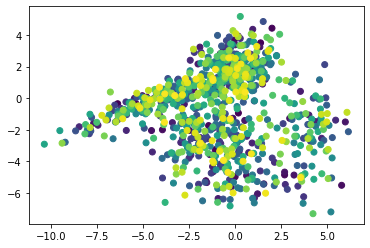

In [4]:
plt.scatter(train_xs[:,0], train_xs[:,1], c=np.arange(0,len(train_xs)))

In [9]:
train_not_tied = dict()
for c in range(2,9):
    model = init_not_tied(c)
    train_not_tied[c] = model.experiment(train_xs, dev_xs, 10)
    print('Cluster {} done'.format(c))

Cluster 2 done
Cluster 3 done
Cluster 4 done
Cluster 5 done
Cluster 6 done
Cluster 7 done
Cluster 8 done


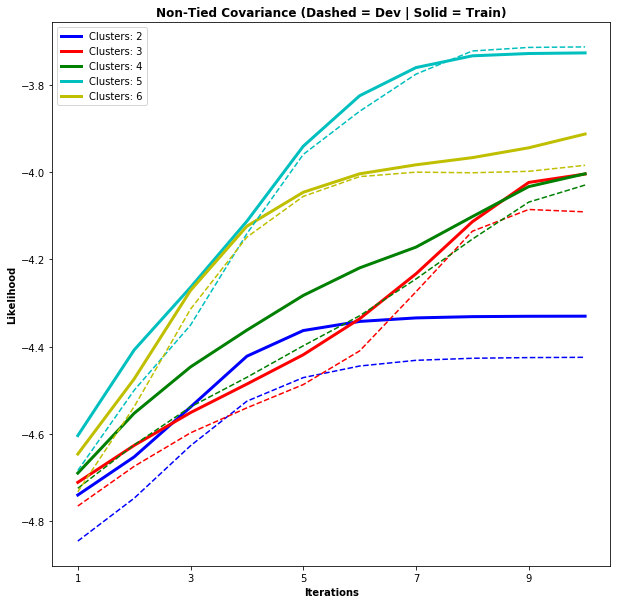

In [29]:
fig = plt.figure(figsize=(10,10))
colors = ['b', 'r', 'g', 'c', 'y']
for l,c in zip(train_not_tied.keys(), colors):
    plt.plot(train_not_tied[l][0][1::], c=c, label='Clusters: {}'.format(l), linewidth=3)
plt.legend()
for l,c in zip(train_not_tied.keys(), colors):
    plt.plot(train_not_tied[l][1][1::], c=c, label='Clusers: {}'.format(l), linestyle='dashed')
plt.xticks(np.arange(0, 10, 2), np.arange(1, 11, 2))
plt.title('Non-Tied Covariance (Dashed = Dev | Solid = Train)', fontweight='bold')
plt.xlabel('Iterations', fontweight='bold')
plt.ylabel('Likelihood', fontweight='bold')
plt.savefig('Non_tied_gauss.png', dpi=150)
plt.show()

In [24]:
train_not_tied[5][1][-1]

-3.712977754534744

## Experiments for the tied case

In [11]:
# Define some initial parameters
# Not tied
def init_tied(cluster_num):
    num_clusters = cluster_num
    mus = np.random.rand(num_clusters, 2)
    initials = np.random.rand(num_clusters)
    initials /= initials.sum()
    transitions = np.random.rand(num_clusters, num_clusters)
    transitions /= transitions.sum(1).reshape(-1,1)

    sigmas = np.random.rand(2,2) * np.identity(2)
    return Gaus_HMM(mus, sigmas, transitions, initials)

In [12]:
train_tied = dict()
for c in range(2,9):
    model = init_tied(c)
    train_tied[c] = model.experiment(train_xs, dev_xs, 20)
    print('Cluster {} done'.format(c))

Cluster 2 done
Cluster 3 done
Cluster 4 done
Cluster 5 done
Cluster 6 done


C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

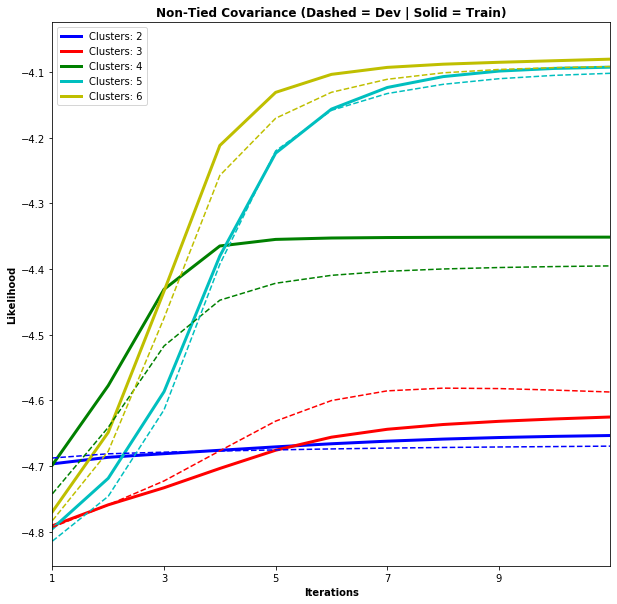

In [20]:
fig = plt.figure(figsize=(10,10))
colors = ['b', 'r', 'g', 'c', 'y']
for l,c in zip(train_tied.keys(), colors):
    plt.plot(train_tied[l][0][1::], c=c, label='Clusters: {}'.format(l), linewidth=3)
plt.legend()
for l,c in zip(train_tied.keys(), colors):
    plt.plot(train_tied[l][1][1::], c=c, label='Clusers: {}'.format(l), linestyle='dashed')
plt.xlim(0,10)
plt.xticks(np.arange(0, 10, 2), np.arange(1, 11, 2))
plt.title('Non-Tied Covariance (Dashed = Dev | Solid = Train)', fontweight='bold')
plt.xlabel('Iterations', fontweight='bold')
plt.ylabel('Likelihood', fontweight='bold')
plt.savefig('Non_tied_gauss.png', dpi=150)
plt.show()

In [28]:
train_tied[6][1][-1]

-4.100158815471492